In [66]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

This is a template for your final project. 

In [67]:
full_dataset = pd.read_csv('IMDb movies.csv')
full_dataset.head(3)

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,NaN,Charles Tait,...,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,537,$ 2250,NaN,NaN,NaN,7.0,7.0
1,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.9,171,NaN,NaN,NaN,NaN,4.0,2.0
2,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,420,$ 45000,NaN,NaN,NaN,24.0,3.0


### Part 1.

Task formalization and Evaluation criteria

### 1.1 Select your target variable, explain your choice. Separate target variable from the feature matrix.

Since we need to come up with a ML model to measure and predict the success of a movie it makes sense to choose a target variable from our dataset which can serve as some proxy of a movie's success. The potential candidates would be `avg_note`, `usa_gross_income`, `worldwise_gross_income`, `metascore` - which are variables that define either some sort of rating or the box office of the movie (i.e. gross income) and can be both considered as a measure of success of a movie. Let's check what proportion of these variables is missing:

In [68]:
full_dataset[['avg_vote', 'usa_gross_income', 
              'worlwide_gross_income', 'metascore']].isna().sum() / full_dataset.shape[0]

avg_vote                 0.000000
usa_gross_income         0.802452
worlwide_gross_income    0.682116
metascore                0.853616
dtype: float64

We see that around 70-80% of data is missing for `usa_gross_income` and `worlwide_gross_income`, therefore it would be impractical to use one of them as a target variable. The same goes to `metascore` variable. Therefore, it makes sense for the film-making company to use `avg_vote` variable as a measure of success for a movie. As an example, the decision making process for the company could be as follows: the company decides to produce a movie only if the predicted rating is above the certain threshold, otherwise it doesn't produce it.

That being said, I think we also need to adjust `avg_vote` by the number of votes. For example, if a movie receives 9 out of 10 from 5 voters it doesn't necessarily mean that the rating is higher than for a movie with 8.9 rating from a thousand voters. Let's check it for some arbitrary high rating:

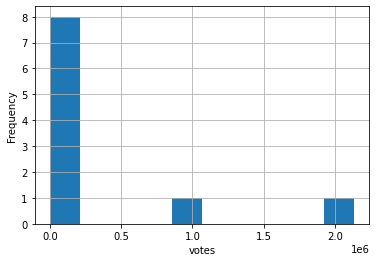

In [69]:
full_dataset[full_dataset['avg_vote'] == 9.0]['votes'].plot(kind='hist');
plt.xlabel('votes')
plt.grid()

In [70]:
full_dataset[full_dataset['avg_vote'] == 9.0][['title', 'avg_vote', 'votes']].sort_values(['votes'], ascending=False)

,title,avg_vote,votes
46756,The Dark Knight,9.0,2134569
15954,The Godfather: Part II,9.0,1032047
37286,Hababam Sinifi Sinifta Kaldi,9.0,20024
37370,Tosun Pasa,9.0,19637
19824,Maratonci trce pocasni krug,9.0,13305
41886,Sandesham,9.0,2936
23574,Vreme na nasilie,9.0,1928
38934,Opasen char,9.0,1468
51732,Shindisi,9.0,180
51858,Officer Arjun Singh IPS,9.0,115


Well it's clear that although having the same rating, the movie like 'The Godfather: Part II' is much more popular than 'Vreme na nasilie' with only few votes. Therefore, it's necessary for us to weight the target `avg_vote` by using the variable `votes`. Let's use the similar approach that IMDb uses for its top 250 movies (https://help.imdb.com/article/imdb/track-movies-tv/ratings-faq/G67Y87TFYYP6TWAV#):

weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C

Where:

R = average for the movie (mean) = (rating)

v = number of votes for the movie = (votes)

m = minimum votes required to be listed in the Top Rated list (currently 25,000)

C = the mean vote across the whole report

Let's apply it to our dataset now:

In [71]:
full_dataset['wtd_avg_vote'] = full_dataset['votes']/(full_dataset['votes'] + 25e3) * full_dataset['avg_vote'] + \
    25e3/(full_dataset['votes'] + 25e3) * full_dataset['avg_vote'].mean()

Let's check if it fixed the issue from above:

In [72]:
full_dataset[full_dataset['avg_vote'] == 9.0][['title', 'avg_vote', 'wtd_avg_vote', 'votes']].sort_values(['votes'], ascending=False)

,title,avg_vote,wtd_avg_vote,votes
46756,The Dark Knight,9.0,8.965240,2134569
15954,The Godfather: Part II,9.0,8.928985,1032047
37286,Hababam Sinifi Sinifta Kaldi,9.0,7.332750,20024
37370,Tosun Pasa,9.0,7.318295,19637
19824,Maratonci trce pocasni krug,9.0,7.040301,13305
41886,Sandesham,9.0,6.312919,2936
23574,Vreme na nasilie,9.0,6.212334,1928
38934,Opasen char,9.0,6.163885,1468
51732,Shindisi,9.0,6.018813,180
51858,Officer Arjun Singh IPS,9.0,6.011098,115


Now `wtd_avg_note` actually makes more sense. Let's now separate the target variable `wtd_avg_vote` from the feature set:

In [73]:
X = full_dataset.drop(['avg_vote', 'wtd_avg_vote', 'votes'], axis=1)
y = full_dataset['wtd_avg_vote']

### 1.2 Explain which task are you going to solve (is it a regression, classification or something else)? 

Since the decision of the company comes down to either produce a movie or not depending on the predicted rating (`wtd_avg_vote`), I think it makes sense to transform our target variable from continuous to a binary one and solve the classification task. One of the ways to come up with the threshold is to look at the distribution of `wtd_avg_vote`:

count    60198.000000
mean         6.054640
std          0.269320
min          2.838021
25%          5.988364
50%          5.999973
75%          6.023595
max          9.262206
Name: wtd_avg_vote, dtype: float64

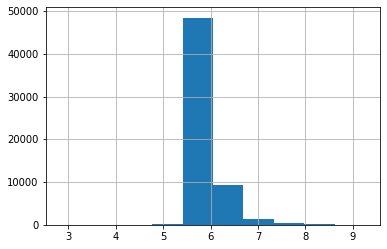

In [74]:
y.hist()
y.describe()

As we can see, both median and mean `wtd_avg_vote` come around 6.0, therefore I think we are safe to assume that a movie can be deemed successful if it gets `wtd_avg_vote` $\ge$ 6.0 (out of 10) and everything below that can be considered average or unsuccessful. Therefore, let's transform our target varible to the binary one:

In [75]:
rating_success_threshold = 6.0

y_bin = y.apply(lambda x: 1. if x >= rating_success_threshold else 0)

I believe solving a classification task is more beneficial for us rather than a regression task since all ratings below average are in a sense equally bad for the film-making company since it likely won't generate enough profit for them, therefore there is no need for us to distinguish them, so we should focus on prediciting either the movies is going to be successful or not using binary `avg_vote` target.

1.3 Select a metric. Is it already implemented in sklearn? If yes, import it. If not, it is time to write a function which will calculate it. 

Let's check if we are dealing with the case of imbalanced classification. For that let's plot the distribution of classes:

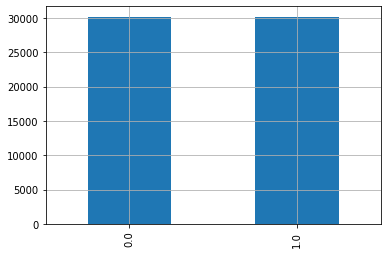

In [76]:
y_bin.value_counts().plot(kind='bar')
plt.grid()
plt.show()

As we can see, for the rating_success_threshold equal to 6 we are getting balanced classes as expected. Since for the film-making company it's important to make profit, we need to maximize the number of correct predictions on success of a movie. For that we can use precision, which quantifies the number of correct positive predictions made. But at the same time we don't want to miss out on investing into would-be successful movies, which can be quantified with recall - the number of correct positive predictions made out of all positive predictions that could have been made. Since both are improtant to us, let's use the F1 metric, which represents the weighted average of the precision and recall.

In [77]:
from sklearn.metrics import f1_score

### Part 2.

Explore and preprocess the data

### 2.1 Split data into train and test

In the further exploratory data analysis on train dataset we are going to use both the continuous target variable (y_train) and binary (y_bin_train). We might want to run some correlations between the features and the target variable, which should be more informative using the continuous target variable:

In [78]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_bin_train, y_bin_test = train_test_split(X, y_bin, test_size=0.4, random_state=42)
y_train = y[X_train.index]

### 2.2 Explore you data: make plots, print tables. Make sure to write your observations.  Do not forget to fill-in missing values, define relevant columns transformatios. 


In [79]:
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline

### Missing values

First let's see if we have some variables which have more than 50% of data missing:

In [80]:
prop_missing = X_train.isna().sum() / X_train.shape[0]
prop_missing[prop_missing > 0.5]

budget                   0.721524
usa_gross_income         0.803533
worlwide_gross_income    0.682845
metascore                0.854366
dtype: float64

Since around 85% of `metascore` is missing and it represents the alternative to IMDb rating, we can safely drop this feature. Features `usa_gross_income` and `worldwide_gross_income` not only have more than 65% of missing values but also represent forward-looking features since when the company invests into the production of a movie it can't possible know about its future income, therefore to keep it more to the real-life conditions we have to drop them as well:

In [81]:
X_train = X_train.drop(['metascore', 'usa_gross_income', 'worlwide_gross_income'], axis=1)
X_test = X_test.drop(['metascore', 'usa_gross_income', 'worlwide_gross_income'], axis=1)

Around 70% of `budget` observations are also missing. However, the budget of a movie might be a useful feature since higher budget might lead to a higher rating, but first we need to split the currency pair in which budget is denominated:

In [82]:
X_train['budget_ccy'] = X_train['budget'].apply(lambda x: x.split(' ')[0] if not pd.isnull(x) else x)
X_train['budget'] = X_train['budget'].apply(lambda x: x.split(' ')[1] if not pd.isnull(x) else x)

X_test['budget_ccy'] = X_test['budget'].apply(lambda x: x.split(' ')[0] if not pd.isnull(x) else x)
X_test['budget'] = X_test['budget'].apply(lambda x: x.split(' ')[1] if not pd.isnull(x) else x)

In [83]:
X_train['budget_ccy'].unique()

array([nan, 'CZK', '$', 'EUR', 'JPY', 'INR', 'CNY', 'HUF', 'CAD', 'AUD',
       'GBP', 'ITL', 'BRL', 'FIM', 'DEM', 'FRF', 'ARS', 'ESP', 'PLN',
       'EGP', 'SEK', 'DKK', 'SGD', 'BGL', 'NOK', 'ZAR', 'NZD', 'EEK',
       'JMD', 'HKD', 'TRL', 'MXN', 'PKR', 'PTE', 'CHF', 'RUR', 'NLG',
       'KRW', 'ISK', 'ATS', 'ROL', 'THB', 'LVL', 'IRR', 'PHP', 'IDR',
       'BEF', 'NGN', 'MTL', 'DOP', 'LTL', 'COP', 'CLP', 'UAH', 'MYR',
       'SKK', 'VEB', 'ILS', 'HRK', 'TWD', 'BDT', 'YUM'], dtype=object)

In [84]:
X_train['year'].sort_values().unique()

array([1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921,
       1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932,
       1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943,
       1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
      dtype=int64)

As we can see there are quite a few currency pairs in which budgets are denominated. Moreover, in our dataset movies are present from 1911 to 2019, therefore it would be hard to consolidate all of them to some common denominated value (e.g. USD) and calculate correlations with the target variable. Instead, let's check if on average the rating is higher for the observations in which budget is present. If it holds true, we can transform `budget` variable into a binary feature depending on either it's present or not. If the assumption doesn't hold, we won't be able to use this feature in any useful way and will drop it:

In [85]:
sample_missing = y_train[X_train[X_train['budget'].isna()].index].values
sample_present = y_train[X_train[~X_train['budget'].isna()].index].values

To test our hypothesis let's use t-test for two independent samples. For that we formulate the following hypothesis:

$H_0\colon$ average ratings are equal for observations with missing budget and without missing budget.

$H_1\colon$ average rating is higher for the observations with present budget

Before using the t-test let's check if there are no gross deviations from the normality:

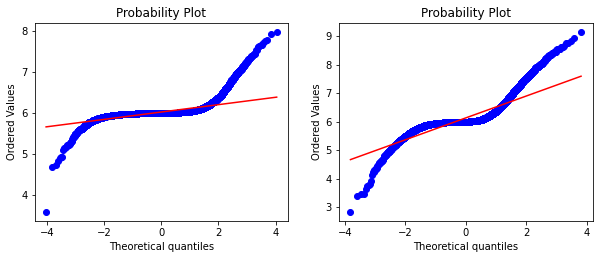

Missing budget sample size: 26060
Present budget sample size: 10058


In [86]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
stats.probplot(sample_missing, dist='norm', plot=plt)
plt.subplot(2, 2, 2)
stats.probplot(sample_present, dist='norm', plot=plt)
plt.show()
print('Missing budget sample size:', len(sample_missing))
print('Present budget sample size:', len(sample_present))

As we can see there are visible deviations in the tails but the sample sizes are big enought for CLT to start working so we should be safe:

In [87]:
res = stats.ttest_ind(sample_present, sample_missing, equal_var=False)
print(f'T test (one-sided): pvalue={res[1]/2}')

T test (one-sided): pvalue=8.435486474931808e-130


pvalue is much less than 0.05, therefore we can reject the null hypothesis in favour of alternative, which means that movie observations with present budget have on average higher rating. Therefore, we can transform `budget` variable in binary variable `has_budget` in the following manner:

In [88]:
X_train['has_budget'] = X_train['budget'].apply(lambda x: 0 if pd.isnull(x) else 1)
X_test['has_budget'] = X_test['budget'].apply(lambda x: 0 if pd.isnull(x) else 1)

del sample_missing, sample_present

Finally let's test one more hypothesis that movies that have USD budget have on average higher rating:

$H_0\colon$ average ratings are equal for observations with USD budget and other denominated budgets

$H_1\colon$ average rating is higher for the observations with USD budget

In [89]:
sample_usd = y_train[X_train[X_train['budget_ccy'] == '$'].index].values
sample_non_usd = y_train[X_train[(X_train['budget_ccy'] != '$') & (~X_train['budget_ccy'].isna())].index].values

print('USD budget movies sample size:', len(sample_usd))
print('non-USD budget movies sample size:', len(sample_non_usd))

USD budget movies sample size: 7642
non-USD budget movies sample size: 2416


In [90]:
res = stats.ttest_ind(sample_usd, sample_non_usd, equal_var=False)
print(f'T test (one-sided): pvalue={res[1]/2}')

T test (one-sided): pvalue=8.11610989191985e-31


Again pvalue is much less than 0.05, therefore we can reject the null hypothesis in favour of alternative. Let's create new binary variable `usd_budget` and drop `budget` and `budget_ccy` from both train and test as we won't need them longer:

In [91]:
X_train['usd_budget'] = X_train['budget_ccy'].apply(lambda x: 1 if x == '$' else 0)
X_test['usd_budget'] = X_test['budget_ccy'].apply(lambda x: 1 if x == '$' else 0)

X_train = X_train.drop(['budget', 'budget_ccy'], axis=1)
X_test = X_test.drop(['budget', 'budget_ccy'], axis=1)

del sample_usd, sample_non_usd

Now let's look at features with less than 50% missing values:

In [92]:
prop_missing[(prop_missing > 0.) & (prop_missing <= 0.5)]

country                 0.000111
language                0.007143
director                0.000443
writer                  0.013151
production_company      0.045684
actors                  0.000471
description             0.032698
reviews_from_users      0.068581
reviews_from_critics    0.136635
dtype: float64

Missing values for features like `reviews_from_users`, `reviews_from_critics` can be imputed using means. For features like `country`, `language` we can use most frequent values but let's first transform them to take the first value in the series:

In [93]:
X_train = X_train.drop(['reviews_from_users', 'reviews_from_critics'], axis=1)
X_test = X_test.drop(['reviews_from_users', 'reviews_from_critics'], axis=1)

In [94]:
X_train['language'] = X_train['language'].apply(lambda x: x if pd.isnull(x) else x.split(', ')[0])
X_train['country'] = X_train['country'].apply(lambda x: x if pd.isnull(x) else x.split(', ')[0])

X_test['language'] = X_test['language'].apply(lambda x: x if pd.isnull(x) else x.split(', ')[0])
X_test['country'] = X_test['country'].apply(lambda x: x if pd.isnull(x) else x.split(', ')[0])

I think we can simply drop the missing observations for features `director` and `actors` since there are only few missing:

In [95]:
X_train[['director', 'actors']].isna().sum()

director    16
actors      17
dtype: int64

In [96]:
X_train = X_train.dropna(subset=['director', 'actors'])
y_train = y_train[X_train.index]
y_bin_train = y_bin_train[X_train.index]

X_test = X_test.dropna(subset=['director', 'actors'])
y_bin_test = y_bin_test[X_test.index]

Features like `production_company` and `writer` I would like to impute with the most frequent value grouped by the year of issue. For that we would need to implement MostFreqGroupImputer class:

In [97]:
class MostFreqGroupImputer(BaseEstimator, TransformerMixin):
    '''
    Class used for imputing missing values in a pd.DataFrame using the most frequent value within group
    
    Parameters
    ----------    
    group_cols : str
        A column used to calculate the mode
    Returns
    -------
    X : array-like
        The array with imputed values in the target column
    '''
    def __init__(self, group_col):
        assert type(group_col) == str, 'group_col should be a string'

        self.group_col = group_col
    
    def fit(self, X, y=None):
        assert X[self.group_col].isna().sum() == 0, 'There are missing values in the group_col'
        
        # Group dataset by `group_col` and calculate mode of all the other columns within this group
        self.mapping = X.groupby(self.group_col).agg(lambda x: stats.mode(x)[0])
        return self 
    
    def transform(self, X, y=None):
        X = X.copy()
        # make sure that the imputer was fitted
        assert self.mapping is not None
        
        # loop over all the groups
        for index, row in self.mapping.iterrows():
            
            # Fill in missing values for the group `index` with the values `row`            
            # your code here
            X.loc[(X[self.group_col] == index) & (X.isna().any(axis=1))] = \
                X[(X[self.group_col] == index) & (X.isna().any(axis=1))].fillna(row)
        
        return X.values

### Categorical variables

In [98]:
X_train[X_train.columns[X_train.dtypes == 'object']].describe()

,imdb_title_id,title,original_title,date_published,genre,country,language,director,writer,production_company,actors,description
count,36086,36086,36086,36086,36086,36082,35833,36086,35623,34450,36086,34908
unique,36086,34944,34947,15163,1012,128,123,16537,30164,14965,36075,34881
top,tt0093506,The Three Musketeers,The Three Musketeers,2008,Drama,USA,English,Jesús Franco,Jing Wong,Metro-Goldwyn-Mayer (MGM),"Nobuyo Ôyama, Noriko Ohara, Michiko Nomura, Ka...",Mail
freq,1,6,6,63,5122,14294,19402,52,41,786,6,3


First of all, we can drop `imdb_title_id` variable since it's just a random identifier assigned to each movie. We can drop it both for train and test data. We also can drop `original_title` since it seems to be identical to the `title` feature. At the same time, feature `title` has just too many unique values (which is natural for the movie industry), therefore I think we won't be able to obtain any useful information from it and can drop it as well:

In [99]:
X_train = X_train.drop(['imdb_title_id', 'original_title', 'title'], axis=1)
X_test = X_test.drop(['imdb_title_id', 'original_title', 'title'], axis=1)

`date_published` is not really a categorical variable, so let's parse all the publish dates and and break into two new variables `day` and `month` and drop the original one. We can do it both for the train and test data:

In [100]:
X_train['date_published'] = pd.to_datetime(X_train['date_published'])
X_train['day'] = X_train['date_published'].dt.day
X_train['month'] = X_train['date_published'].dt.month
X_train = X_train.drop(['date_published'], axis=1)

X_test['date_published'] = pd.to_datetime(X_test['date_published'])
X_test['day'] = X_test['date_published'].dt.day
X_test['month'] = X_test['date_published'].dt.month
X_test = X_test.drop(['date_published'], axis=1)

Now let's transform the feature `genre`. For that we would need to check how many unique values there actually are:

In [101]:
genres = set()
X_train['genre'].apply(lambda x: genres.update(x.split(', ')))

print('Unique genres:', len(genres))

Unique genres: 24


As we can see there are not that many unique genres so we should be just able to do k-hot encoding i.e. genres present in the movie are encoded with 1 and others are 0:

In [102]:
X_train = pd.concat([X_train.drop('genre', 1), X_train['genre'].str.get_dummies(sep=', ').add_prefix('genre_')], axis=1)
X_test = pd.concat([X_test.drop('genre', 1), X_test['genre'].str.get_dummies(sep=', ').add_prefix('genre_')], axis=1)

# missing genres in test
missing_genres = list(set(filter(lambda x: 'genre_' in x, X_train.columns)) - set(filter(lambda x: 'genre_' in x, X_test .columns)))
print('Missing genres in test:', ', '.join(missing_genres))
X_test[missing_genres] = pd.DataFrame(np.zeros((X_test.shape[0], len(missing_genres))), index=X_test.index)

Missing genres in test: genre_Reality-TV, genre_Documentary


Features like `country`, `language` and `production_company` have much more unique values, so instead of resorting to OneHotEncoding let's flag the ones that are considered successful (i.e. have mean `wtd_avg_vote` $\ge 6.0$) and then use OrdinalEncoder to encode original features in order of popularity (e.g. top 10 countries/languages/production companies by frequency). First of all we need to transform `production_company` feature to take only the first company in the series:

In [103]:
X_train['production_company'] = X_train['production_company'].apply(lambda x: x.split(', ')[0] if not pd.isnull(x) else x)
X_test['production_company'] = X_test['production_company'].apply(lambda x: x.split(', ')[0] if not pd.isnull(x) else x)

Now let's implement the method that would get us the popularity of supplied features by taking top N frequently met values. We will need it later for OrdinalEncoder:

In [104]:
def get_frequencies(X_train, feautures: list, threshold: int, verbose=True):
    res = {}
    for feature in feautures:
        res[feature] = X_train[feature].value_counts().sort_values()[-threshold:].index.tolist()
        if verbose:
            print(f'Most {threshold} popular {feature}:', ', '.join(res[feature]), '\n')
    return res

In [105]:
freq = get_frequencies(X_train, ['country', 'language', 'production_company'], threshold=15)

Most 15 popular country: South Korea, Sweden, Australia, Soviet Union, Turkey, Spain, Hong Kong, Germany, Canada, Japan, Italy, India, France, UK, USA 

Most 15 popular language: Danish, Swedish, Korean, Portuguese, Mandarin, Turkish, Cantonese, Russian, Hindi, German, Spanish, Japanese, Italian, French, English 

Most 15 popular production_company: Walt Disney Productions, First National Pictures, Shaw Brothers, Republic Pictures (I), New Line Cinema, Canal+, Universal International Pictures (UI), Mosfilm, RKO Radio Pictures, Universal Pictures, Twentieth Century Fox, Columbia Pictures, Paramount Pictures, Warner Bros., Metro-Goldwyn-Mayer (MGM) 



Now let's implement a helper method to add a flag to features with values that are considered successful (i.e. have mean `wtd_avg_vote` $\ge 6.0$ ):

In [106]:
def add_success_flags(X_train, X_test, y_train, features, threshold=rating_success_threshold, verbose=True):
    X_train['wtd_avg_vote'] = y_train
    
    for feature in features:
        successful = X_train.groupby([feature])['wtd_avg_vote'].mean()
        successful = successful[successful >= threshold].index.tolist()
        
        if verbose:
            print(f'Successful {feature}:', ', '.join(successful))
        
        X_train[f'successful_{feature}'] = X_train[feature].apply(lambda x: 1 if pd.isnull(x) or x in successful else 0)
        X_test[f'successful_{feature}'] = X_test[feature].apply(lambda x: 1 if pd.isnull(x) or x in successful else 0)
    
    X_train = X_train.drop(['wtd_avg_vote'], axis=1)
    
    return X_train, X_test

In [107]:
X_train, X_test = add_success_flags(X_train, X_test, y_train, ['country', 'language', 'production_company'], verbose=False)

Let's now check how many unique `director`, `actors` and `writer` values are presented in the datasets:

In [108]:
directors, writers, actors = set(), set(), set()
X_train['director'].apply(lambda x: directors.update(x.split(', ')) if not pd.isnull(x) else _)
X_train['writer'].apply(lambda x: writers.update(x.split(', ')) if not pd.isnull(x) else _)
X_train['actors'].apply(lambda x: actors.update(x.split(', ')) if not pd.isnull(x) else _)

X_test['director'].apply(lambda x: directors.update(x.split(', ')) if not pd.isnull(x) else _)
X_test['writer'].apply(lambda x: writers.update(x.split(', ')) if not pd.isnull(x) else _)
X_test['actors'].apply(lambda x: actors.update(x.split(', ')) if not pd.isnull(x) else _)

print('Unique directors:', len(directors))
print('Unique writers:', len(writers))
print('Unique actors:', len(actors))

Unique directors: 22513
Unique writers: 42958
Unique actors: 294879


As we can see there are too many unique values for `director`, `actors` and `writer` so we can't possibly do OHE for these. Therefore, let's repeat the same approach as we did for `country`, `language` and `production_company`. For that we would first need to get frequencies for these features, we will take 15 first actors/writers/directors for each movie and calculated how frequently they are encountered across the dataset. Finally, we will store 250 most frequently met people for OrdinalEncoder later:

In [109]:
for feature in ['director', 'actors', 'writer']:
    res = []
    X_train[feature].apply(lambda x: res.extend(x.split(', ')[:15]) if not pd.isnull(x) else _)
    freq[feature] = pd.Series(res).value_counts().sort_values()[-250:].index.tolist()

Now let's try to get the sets of the most successful people and include them in a form of a binary variables like we did before:

In [110]:
X_train['wtd_avg_vote_binary'] = y_bin_train

for feature in ['director', 'actors', 'writer']:
    res = []
    X_train[X_train['wtd_avg_vote_binary'] == 1][feature].apply(lambda x: res.extend(x.split(', ')[:15]) if not pd.isnull(x) else _)
    counts = pd.Series(res).value_counts().sort_values()
    counts = counts[counts > counts.mean()]
    successful = set(counts.index.tolist())
    
    # it's ok to put 1 when we have NaN since we are going to drop observations with missing actors, directors
    X_train[f'successful_{feature}'] = X_train[feature].apply(lambda x: len(set(x.split(', ')[:15]) & successful) \
                                                              if not pd.isnull(x) else 0)
    X_test[f'successful_{feature}'] = X_test[feature].apply(lambda x: len(set(x.split(', ')[:15]) & successful) \
                                                             if not pd.isnull(x) else 0)
    
X_train = X_train.drop(['wtd_avg_vote_binary'], axis=1)

Let's check if our heuristics actually makes sense on example with movies of Christopher Nolan since he is usually considered a successful directors with strongs casts:

In [111]:
X_train[X_train['director'] == 'Christopher Nolan'][['director', 'writer', 'actors', 'successful_director', 'successful_actors', 'successful_writer']]

,director,writer,actors,successful_director,successful_actors,successful_writer
35417,Christopher Nolan,"Christopher Nolan, Jonathan Nolan","Guy Pearce, Carrie-Anne Moss, Joe Pantoliano, ...",1,8,2
42664,Christopher Nolan,"Bob Kane, David S. Goyer","Christian Bale, Michael Caine, Liam Neeson, Ka...",1,13,2
55287,Christopher Nolan,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellen...",1,12,1
47427,Christopher Nolan,"Jonathan Nolan, Christopher Nolan","Hugh Jackman, Christian Bale, Michael Caine, P...",1,12,2
55050,Christopher Nolan,"Jonathan Nolan, Christopher Nolan","Christian Bale, Gary Oldman, Tom Hardy, Joseph...",1,13,2
48940,Christopher Nolan,"Jonathan Nolan, Christopher Nolan","Ellen Burstyn, Matthew McConaughey, Mackenzie ...",1,12,2
32413,Christopher Nolan,Christopher Nolan,"Jeremy Theobald, Alex Haw, Lucy Russell, John ...",1,1,1


Feature `description` obviously would have too many unique values, therefore the only way for us to make use of it would be to encode observations where popular words are encountered. However, this would require filtering our most popular words with regards to stopwords which is usually a part of NLP libraries like NLTK. Given that we are not working with this library as a part of this project there is seemingly no useful way for us to use this feature, hence we will drop it:

In [112]:
X_train = X_train.drop(['description', 'writer', 'director', 'actors'], axis=1)
X_test = X_test.drop(['description', 'writer', 'director', 'actors'], axis=1)

In [113]:
X_train[X_train.columns[X_train.dtypes == 'object']].describe()

,country,language,production_company
count,36082,35833,34450
unique,128,123,14962
top,USA,English,Metro-Goldwyn-Mayer (MGM)
freq,14294,19402,786


In [114]:
class MyOrdinalEncoder(BaseEstimator, TransformerMixin):
    '''
    Class used for encoding categorical features in a pd.DataFrame using the supplied categories and constant for unknown values
    
    Parameters
    ----------    
    group_cols : str
        A column used to calculate the mean values
    Returns
    -------
    X : array-like
        The array with imputed values in the target column
    '''
    def __init__(self, categories, unknown_value=0):
        assert type(categories) == list, 'categories should be a list of strings'

        self.categories = categories
        self.unknown_value = unknown_value
    
    def fit(self, X, y=None):
        if type(X) is np.ndarray:
            X = pd.DataFrame(X)
        assert X.isna().sum().sum() == 0, 'There are missing values present!'
        
        return self 
    
    def transform(self, X, y=None):
        X = X.copy()
        if type(X) is np.ndarray:
            X = pd.DataFrame(X)
        
        # loop over all columns
        for col in X.columns[X.dtypes == 'object']:
            X[col] = X[col].apply(lambda x: self.unknown_value if x not in self.categories else self.categories.index(x) + 1)
        
        return X.values

### Numerical variables

In [115]:
X_train.columns[X_train.dtypes != 'object']

Index(['year', 'duration', 'has_budget', 'usd_budget', 'day', 'month',
       'genre_Action', 'genre_Adult', 'genre_Adventure', 'genre_Animation',
       'genre_Biography', 'genre_Comedy', 'genre_Crime', 'genre_Documentary',
       'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_Film-Noir',
       'genre_History', 'genre_Horror', 'genre_Music', 'genre_Musical',
       'genre_Mystery', 'genre_Reality-TV', 'genre_Romance', 'genre_Sci-Fi',
       'genre_Sport', 'genre_Thriller', 'genre_War', 'genre_Western',
       'successful_country', 'successful_language',
       'successful_production_company', 'successful_director',
       'successful_actors', 'successful_writer'],
      dtype='object')

As we can see most of the numerical features were created from transforming our categorical features. However, let's have a closer look at some of them that we haven't touched:

Distribution of numerical features:


c:\users\yaroslav\appdata\local\programs\python\python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


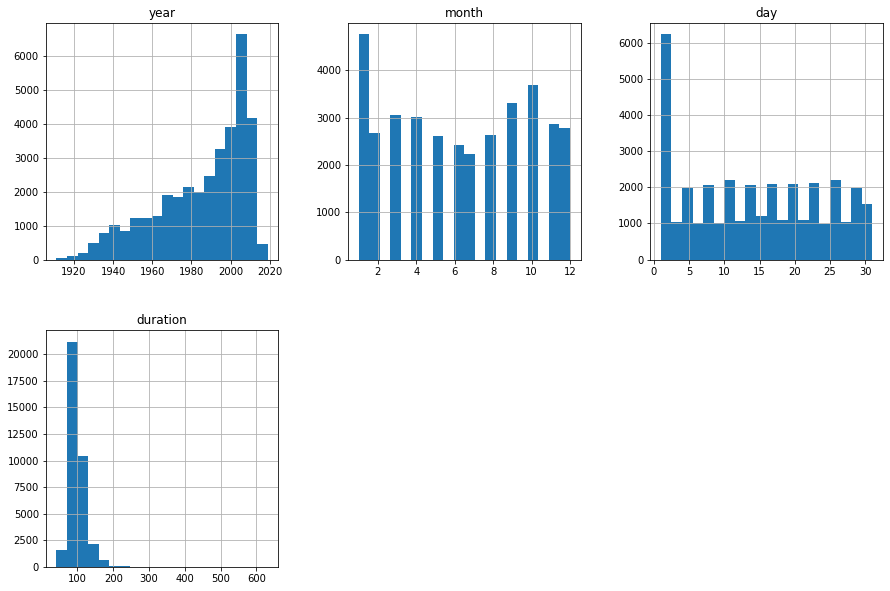

In [116]:
numerical_columns = ['year', 'month', 'day', 'duration']

print("Distribution of numerical features:")
X_train[numerical_columns].hist(bins=20, grid=True, figsize=(15, 10), layout=(2, 3))
plt.show()

Let's check if there is any visible correlation between our numerical features and target:

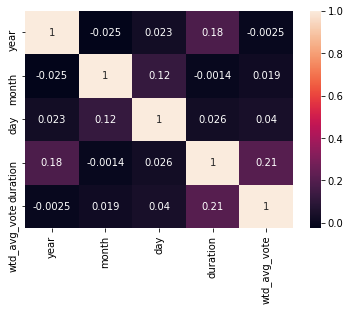

In [117]:
X_train['wtd_avg_vote'] = y_train
corrs = X_train[numerical_columns + ['wtd_avg_vote']].corr()
sns.heatmap(corrs, annot=True)
plt.show()
X_train = X_train.drop(['wtd_avg_vote'], axis=1)

As we can see only `duration` has somewhat non-zero correlation with the target variable so they should be potentially useful for our training dataset. We will apply StandardScaler to our numerical features.

#### Putting all preprocessings together

In [118]:
pipe_language = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    MyOrdinalEncoder(freq['language']),
    StandardScaler()
)
pipe_country = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    MyOrdinalEncoder(freq['country']),
    StandardScaler()
)
pipe_company = make_pipeline(
    MostFreqGroupImputer('year'),
    MyOrdinalEncoder(freq['production_company']),
    StandardScaler()
)

column_transformer = ColumnTransformer([
    ('language', pipe_language, ['language']),
    ('country', pipe_country, ['country']),
    ('company', pipe_company, ['production_company', 'year']),
    ('rest_num', StandardScaler(), ['year', 'month', 'day', 'duration'])
], remainder='passthrough')

### Part 3.

Train and compare the models

### 3.1. Select models, you are going to train, select hyperparameters that have to be tunes.

In [119]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [120]:
model = Pipeline([
    ('preprocessing', column_transformer),
    ('estimator', GradientBoostingClassifier())
])

param_grid = [
    {
        'estimator': [LogisticRegression(solver='liblinear')],
        'estimator__penalty': ['l2', 'l1'],
        'estimator__C': [0.1, 1, 10]
    },
    {
        'estimator': [RandomForestClassifier()],
        'estimator__n_estimators': [100, 150, 200],
        'estimator__max_depth': [10, 20, 30],
    },
    {
        'estimator': [GradientBoostingClassifier()],
        'estimator__n_estimators': [100, 150, 200],
        'estimator__max_depth': [10, 20, 30],
    }
]

### 3.2 Use cross-validation to compare models and select best set of hyperparameters

In [121]:
from sklearn.model_selection import GridSearchCV

In [122]:
grid_pipe = GridSearchCV(model, 
                         param_grid=param_grid,
                         scoring='f1',
                         cv=5,
                         refit=True,
                         n_jobs=None  # for some reason -1 doesn't work for me when I'm trying to run on my local PC but works on coursera
                        )

In [123]:
# with n_jobs=None might take quite a bit of time
grid_pipe.fit(X_train, y_bin_train);

### 3.3 Which model and setup is the best? How does it perform on the test dataset? If you were to present this model to the client, how would you describe it?

In [124]:
print('Best model on CV:')
grid_pipe.best_estimator_[1]

Best model on CV:


RandomForestClassifier(max_depth=20, n_estimators=150)

In [125]:
grid_pipe.best_score_

0.839424867792874

#### Predicting on test:

In [126]:
pred = grid_pipe.best_estimator_.predict(X_test[X_train.columns])

In [127]:
f1_score(y_bin_test, pred)

0.6593667305411077

In [128]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [129]:
print('Accuracy:', accuracy_score(y_bin_test, pred))
print('Precision:', precision_score(y_bin_test, pred))
print('Recall:', recall_score(y_bin_test, pred))

Accuracy: 0.6897053322804538
Precision: 0.7312284962558186
Recall: 0.6003655699567962


If I was tasked with presenting our model (i.e. GradientBoostingClassifier), I would try to keep it simple and say that it uses a number of simple models like decision trees and constructs a more powerful model successively and greedily. Each successive model will try to correct the errors of the previous ones.